In [26]:
import os
import json
import openslide

import pandas
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt

import PySlide
from PySlide.annotations import Annotations

In [27]:
path = 'images/14.90610 C L2.11.json'
labels = {'GC':0}
file_type = 'json'
keys = ['GC']

In [28]:
ann=Annotations(labels, path, file_type, keys)

In [29]:
annotations = ann.generate_annotations(labels)

### PySlide

In [25]:
PySlide.Slide('images/14.90610 C L2.11.ndpi', annotations, border='draw')

Slide('images/14.90610 C L2.11.ndpi')

In [7]:
x = slide.slide_mask((2000,2000))

In [10]:
region, mask = slide.generate_region(mag=4, scale_border=True, factor=256)

x_size:1024
y_size:1024


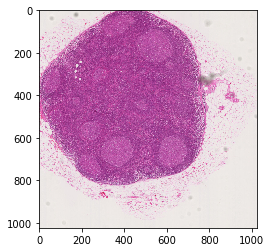

In [11]:
plt.imshow(region)